# Bellman Equation Collocation Method

In [1]:
using BasisMatrices
using QuantEcon
using Optim
using Plots
import PyPlot

In [2]:
struct Interp{N,TM<:AbstractMatrix,TL<:Factorization}
    basis::Basis{N}
    S::Array{Float64,N}
    Scoord::NTuple{N,Vector{Float64}}
    length::Int
    size::NTuple{N,Int}
    lb::NTuple{N,Float64}
    ub::NTuple{N,Float64}
    Phi::TM
    Phi_lu::TL
end

In [3]:
function Interp(basis::Basis)
    S, Scoord = nodes(basis)
    grid_length = length(basis)
    grid_size = size(basis)
    grid_lb, grid_ub = min(basis), max(basis)
    Phi = BasisMatrix(basis, Expanded(), S).vals[1]
    Phi_lu = lufact(Phi)
    interp = Interp(basis, S, Scoord, grid_length, grid_size, grid_lb, grid_ub, Phi, Phi_lu)
end

Interp

For discrete time dynamic programs
with 1-dimenstional continuous states and actions:

In [4]:
struct ContinuousDP{N,K}
    f::Function
    g::Function
    discount::Float64
    shocks::Array{Float64,K}
    weights::Vector{Float64}
    x_lb::Function
    x_ub::Function
    interp::Interp{N}
end

In [5]:
function ContinuousDP(f::Function, g::Function, discount::Float64, 
                      shocks::Array{Float64}, weights::Vector{Float64},
                      x_lb::Function, x_ub::Function,
                      basis::Basis)
    interp = Interp(basis)
    cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, interp)
    return cdp
end

ContinuousDP

In [6]:
function _vmax(cdp::ContinuousDP, s, C; method::Optim.Optimizer=Brent())
    function objective(x)
        out = 0.
        t = Base.tail(indices(cdp.shocks))
        for (i, w) in enumerate(cdp.weights)
            e = cdp.shocks[(i, t...)...]
            out += w * funeval(C, cdp.interp.basis, cdp.g(s, x, e))
        end
        out *= cdp.discount
        out += cdp.f(s, x)
        out *= -1
        return out
    end
    res = optimize(objective, cdp.x_lb(s), cdp.x_ub(s), method=method)
    v = -res.minimum::Float64
    x = res.minimizer::Float64
    return v, x
end

_vmax (generic function with 1 method)

In [7]:
function vmax!(cdp::ContinuousDP, ss::AbstractArray{Float64}, C::Vector{Float64},
               Tv::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        Tv[i], _ = _vmax(cdp, ss[(i, t...)...], C)
    end
    return Tv
end

function vmax!(cdp::ContinuousDP, ss::AbstractArray{Float64}, C::Vector{Float64},
               Tv::Vector{Float64}, X::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        Tv[i], X[i] = _vmax(cdp, ss[(i, t...)...], C)
    end 
    return Tv, X
end

function vmax(cdp::ContinuousDP, ss::AbstractArray{Float64}, C::Vector{Float64})
    n = size(ss, 1)
    Tv, X = Array{Float64}(n), Array{Float64}(n)
    vmax!(cdp, ss, C, Tv, X)
end

vmax (generic function with 1 method)

In [8]:
function bellman_operator!(cdp::ContinuousDP, C::Vector{Float64},
                           Tv::Vector{Float64})
    Tv = vmax!(cdp, cdp.interp.S, C, Tv)
    A_ldiv_B!(C, cdp.interp.Phi_lu, Tv)
    return C
end

bellman_operator! (generic function with 1 method)

In [9]:
function compute_greedy!(cdp::ContinuousDP, ss::AbstractArray{Float64},
                         C::Vector{Float64}, X::Vector{Float64})
    n = size(ss, 1)
    t = Base.tail(indices(ss))
    for i in 1:n
        _, X[i] = _vmax(cdp, ss[(i, t...)...], C)
    end
    return X
end

compute_greedy!(cdp::ContinuousDP, C::Vector{Float64}, X::Vector{Float64}) =
    compute_greedy!(cdp, cdp.interp.S, C, X)

compute_greedy! (generic function with 2 methods)

In [10]:
function evaluate_policy!(cdp::ContinuousDP, X::Vector{Float64}, C::Vector{Float64})
    n = size(cdp.interp.S, 1)
    ts = Base.tail(indices(cdp.interp.S))
    te = Base.tail(indices(cdp.shocks))
    A = copy(cdp.interp.Phi)
    for i in 1:n
        for (j, w) in enumerate(cdp.weights)
            s = cdp.interp.S[(i, ts...)...]
            e = cdp.shocks[(j, te...)...]
            A[i, :] -= cdp.discount * w * vec(evalbase(cdp.interp.basis.params[1], cdp.g(s, X[i], e)))
        end
    end
    A_lu = lufact(A)
    b = Array{Float64}(n)
    for i in 1:n
        s = cdp.interp.S[(i, ts...)...]
        b[i] = cdp.f(s, X[i])
    end
    A_ldiv_B!(C, A_lu, b)
    return C
end

evaluate_policy! (generic function with 1 method)

In [11]:
function operator_iteration!{TC}(T::Function, C::TC;
                                 tol::Float64=1e-4, max_iter::Int=100,
                                 verbose::Int=2, print_skip::Int=50)
    i = 0
    err = tol + 1
    C_old = similar(C)
    while i < max_iter && err > tol
        copy!(C_old, C)
        C = T(C)::TC
        err = maximum(abs, C - C_old)
        i += 1
        
        (i >= max_iter || err <= tol) && break
        
        if (verbose == 2) && (i % print_skip == 0)
            println("Compute iterate $i with error $err")
        end
    end
    
    if verbose == 2
        println("Compute iterate $i with error $err")
    end
    
    if verbose >= 1
        if err > tol
            warn("max_iter attained")
        elseif verbose == 2
            println("Converged in $i steps")
        end
    end
    
    return C
end

operator_iteration! (generic function with 1 method)

## Optimal Economic Growth

In [12]:
n = 10
s_min, s_max = 5, 10;

In [13]:
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb


In [14]:
alpha = 0.2
bet = 0.5
gamm = 0.9
sigma = 0.1
discount = 0.9;

In [15]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

In [16]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
g(s, x, e) = gamm * x + e * x^bet;

In [17]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667])

We follow [mfdp07.m](https://github.com/PaulFackler/CompEcon/blob/56e740e9e2e380318e11f79ce8aca92533a964d6/CEdemos/mfdp07.m#L6)
in CompEcon:

In [18]:
x_lb(s) = 0
x_ub(s) = 0.99 * s;

In [19]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{1,1}(f, g, 0.9, [0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667], x_lb, x_ub, Interp{1,Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}}(1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb
, [5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922], ([5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922],), 10, (10,), (5.0,), (10.0,), [1.0 -0.987688 … 0.309017 -0.156434; 1.0 -0.891007 … -0.809017 0.45399; … ; 1.0 0.891007 … -0.809017 -0.45399; 1.0 0.987688 … 0.309017 0.156434], Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; … ; 1.0 0.0489435 … 1.0 0.0; 1.0 0.579192 … -0.45965 1.0]
[1.0 -0.987688 … 0.309017 -0.156434; 0.0 1.97538 … -1.4877e-14 0.312869; … ; 0.0 0.0 … -5.25731 1.64485; 0.0 0.0 … 0.0 5.06233]))

### Value iteration

In [20]:
tol = sqrt(eps())
max_iter = 250
Tv = Array{Float64}(cdp.interp.length)  # Temporary array
bellman_operator!(C) = bellman_operator!(cdp, C, Tv)
C = zeros(cdp.interp.length)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 50 with error 0.008569366466243622
Compute iterate 100 with error 4.4164588459238985e-5
Compute iterate 150 with error 2.2761436468954344e-7
Compute iterate 176 with error 1.4706344586556952e-8
Converged in 176 steps


In [21]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(cdp, ss, C)
resid = V - funeval(C, cdp.interp.basis, ss);


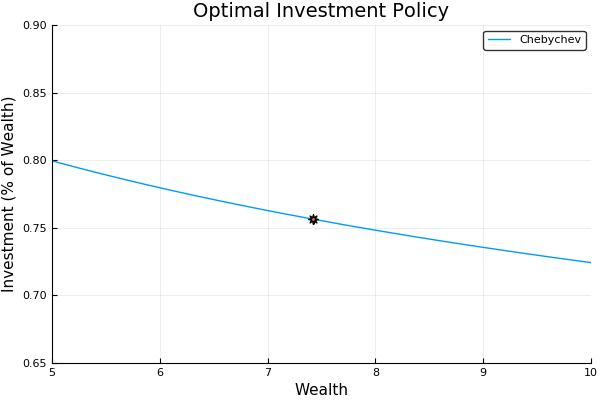

In [22]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


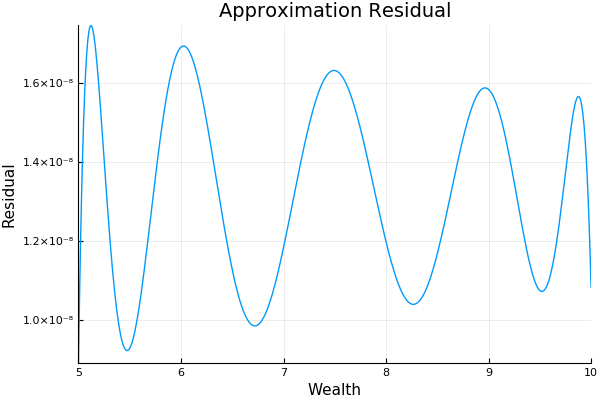

In [23]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [24]:
function policy_iteration_operator!(cdp::ContinuousDP, C::Vector{Float64}, X::Vector{Float64})
    compute_greedy!(cdp, C, X)
    evaluate_policy!(cdp, X, C)
    return C
end

policy_iteration_operator! (generic function with 1 method)

In [25]:
tol = sqrt(eps())
max_iter = 250
X = Array{Float64}(cdp.interp.length)  # Temporary array
policy_iteration_operator!(C) = policy_iteration_operator!(cdp, C, X)
C = zeros(cdp.interp.length)
C = operator_iteration!(policy_iteration_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 6 with error 5.773159728050814e-15
Converged in 6 steps


In [26]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(cdp, ss, C)
resid = V - funeval(C, cdp.interp.basis, ss);


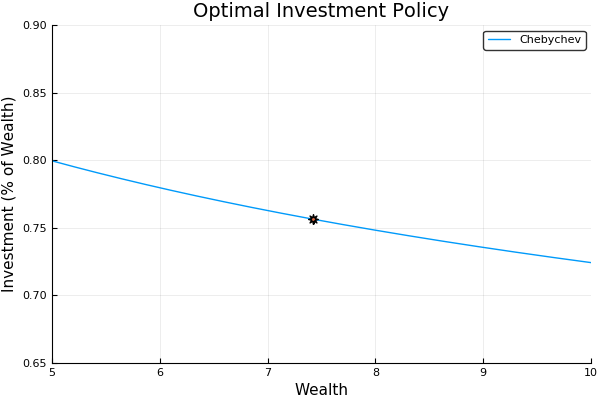

In [27]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(ss, X./ss, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


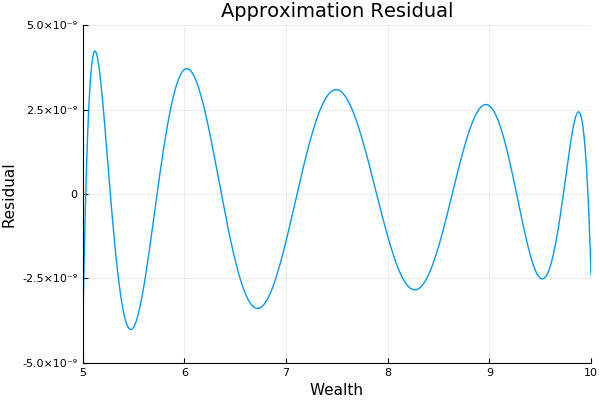

In [28]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-5e-9, 5e-9), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Nonrenewable Resource Management

In [29]:
k = 3
m = 101
breaks = m - (k-1)
s_min, s_max = 0, 10;

In [30]:
basis = Basis(SplineParams(breaks, s_min, s_max, 3))

1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline


In [31]:
a = [10, 0.8]
b = [12, 1.0]
discount = 0.9;

We follow [mfdp09.m](https://github.com/PaulFackler/CompEcon/blob/56e740e9e2e380318e11f79ce8aca92533a964d6/CEdemos/mfdp09.m#L8)
in CompEcon, rather than the book, to reproduce the figures there:

In [32]:
p(x) = a[1] - a[2] * x / 2
c(s, x) = b[1] * x - b[2] * x * (2*s - x) / 2
f(s, x) = p(x) * x - c(s, x)
g(s, x, e) = s - x;

In [33]:
shocks, weights = [0.], [1.];

In [34]:
x_lb(s) = 0
x_ub(s) = s;

In [35]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{1,1}(f, g, 0.9, [0.0], [1.0], x_lb, x_ub, Interp{1,SparseMatrixCSC{Float64,Int64},Base.SparseArrays.UMFPACK.UmfpackLU{Float64,Int64}}(1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline
, [0.0, 0.0340136, 0.102041, 0.204082, 0.306122, 0.408163, 0.510204, 0.612245, 0.714286, 0.816327  …  9.18367, 9.28571, 9.38776, 9.4898, 9.59184, 9.69388, 9.79592, 9.89796, 9.96599, 10.0], ([0.0, 0.0340136, 0.102041, 0.204082, 0.306122, 0.408163, 0.510204, 0.612245, 0.714286, 0.816327  …  9.18367, 9.28571, 9.38776, 9.4898, 9.59184, 9.69388, 9.79592, 9.89796, 9.96599, 10.0],), 101, (101,), (0.0,), (10.0,), 
  [1  ,   1]  =  1.0
  [2  ,   1]  =  0.296296
  [1  ,   2]  =  0.0
  [2  ,   2]  =  0.564815
  [3  ,   2]  =  0.25
  [1  ,   3]  =  0.0
  [2  ,   3]  =  0.132716
  [3  ,   3]  =  0.583333
  [4  ,   3]  =  0.166667
  [1  ,   4]  =  0.0
  ⋮
  [98 ,  99]  =  0.166667
  [99 ,  99]  =  0.583333
  [100,  99]  =  0.132716
  [101,  99]  =  0.0
  [98 , 100] 

### Value iteration

In [36]:
tol = sqrt(eps())
max_iter = 250
Tv = Array{Float64}(cdp.interp.length)  # Temporary array
bellman_operator!(C) = bellman_operator!(cdp, C, Tv)
C = zeros(cdp.interp.length)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 38 with error 1.4533888759160618e-8
Converged in 38 steps


In [37]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(cdp, ss, C)
B1 = evalbase(basis.params[1], ss, 1)
shadow_prices = B1 * C
resid = V - funeval(C, cdp.interp.basis, ss);


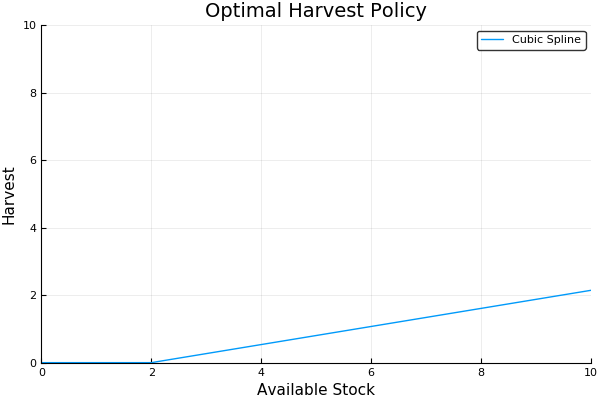

In [38]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(ss, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


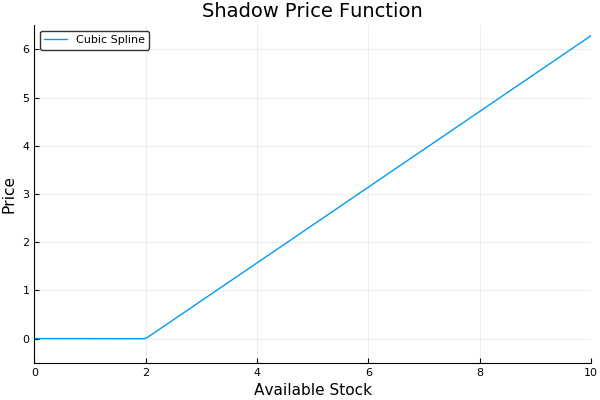

In [39]:
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


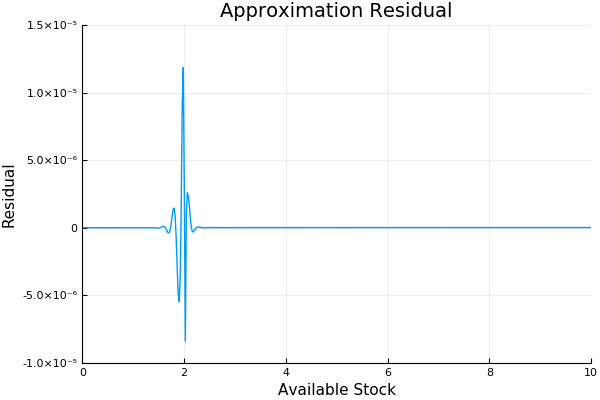

In [40]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [41]:
tol = sqrt(eps())
max_iter = 250
X = Array{Float64}(cdp.interp.length)  # Temporary array
policy_iteration_operator!(C) = policy_iteration_operator!(cdp, C, X)
C = zeros(cdp.interp.length)
C = operator_iteration!(policy_iteration_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 6 with error 1.4210854715202004e-14
Converged in 6 steps


In [42]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
ss = linspace(s_min, s_max, grid_length)
V, X = vmax(cdp, ss, C)
B1 = evalbase(basis.params[1], ss, 1)
shadow_prices = B1 * C
resid = V - funeval(C, cdp.interp.basis, ss);


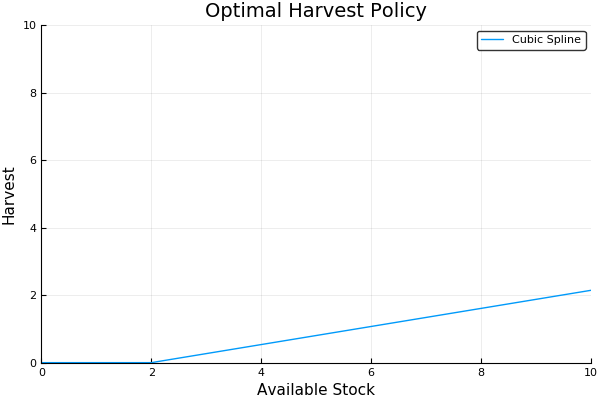

In [43]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(ss, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


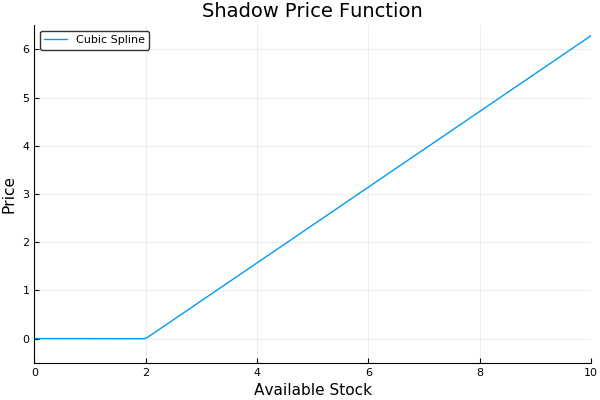

In [44]:
title = "Shadow Price Function"
ylabel = "Price"
plot(ss, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


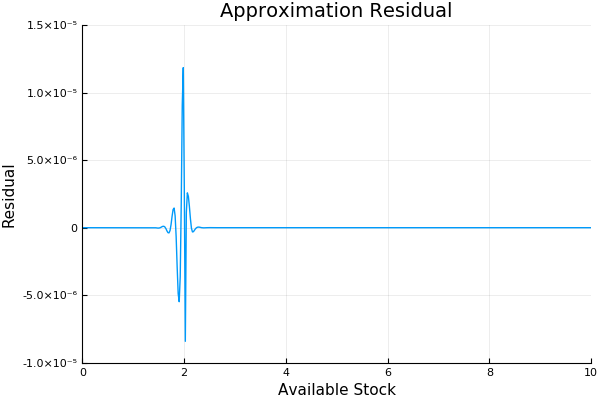

In [45]:
title = "Approximation Residual"
ylabel = "Residual"
plot(ss, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Monetary Policy

In [46]:
bet = [0.8 0.5; 0.2 0.6]
gamm = [-0.8, 0.0]
Omega = [0.3 0.0; 0.0 1.0]
s_target = [0., 1.]
alpha = [0.9, 0.4]
Sigma = 0.04 * eye(2)
discount = 0.9;

In [47]:
f(s, x) = -(s - s_target)' * Omega * (s - s_target) / 2
g(s, x, e) = alpha + bet * s + gamm * x + e
x_lb(s) = 0.
x_ub(s) = 30;

In [48]:
n_shocks = [3, 3]
mu = [0, 0]
shocks, weights = qnwnorm(n_shocks, mu, Sigma)

([-0.34641 -0.34641; 0.0 -0.34641; … ; 0.0 0.34641; 0.34641 0.34641], [0.0277778, 0.111111, 0.0277778, 0.111111, 0.444444, 0.111111, 0.0277778, 0.111111, 0.0277778])

In [49]:
k = [3, 3]
m = [10, 10]
breaks = m - (k-1)
s_min = [-15, -10]
s_max = [15, 10]
basis = Basis(map(SplineParams, breaks, s_min, s_max, k)...)

2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline


In [50]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDP{2,2}(f, g, 0.9, [-0.34641 -0.34641; 0.0 -0.34641; … ; 0.0 0.34641; 0.34641 0.34641], [0.0277778, 0.111111, 0.0277778, 0.111111, 0.444444, 0.111111, 0.0277778, 0.111111, 0.0277778], x_lb, x_ub, Interp{2,SparseMatrixCSC{Float64,Int64},Base.SparseArrays.UMFPACK.UmfpackLU{Float64,Int64}}(2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline
, [-15.0 -10.0; -13.5714 -10.0; … ; 13.5714 10.0; 15.0 10.0], ([-15.0, -13.5714, -10.7143, -6.42857, -2.14286, 2.14286, 6.42857, 10.7143, 13.5714, 15.0], [-10.0, -9.04762, -7.14286, -4.28571, -1.42857, 1.42857, 4.28571, 7.14286, 9.04762, 10.0]), 100, (10, 10), (-15.0, -10.0), (15.0, 10.0), 
  [1  ,   1]  =  1.0
  [2  ,   1]  =  0.296296
  [11 ,   1]  =  0.296296
  [12 ,   1]  =  0.0877915
  [1  ,   2]  =  0.0
  [2  ,   2]  =  0.564815
  [3  ,   2]  =  0.25
  [4  ,   2]  =  1.78017e-47
  [11 ,   2]  =  0.0
  [12 ,   2]  =  0.167353
  ⋮
  [90 ,  99]  =  0.0
  [97 ,  99]  =  1.78017e-4

## Value iteration

In [51]:
tol = sqrt(eps())
max_iter = 250
Tv = Array{Float64}(cdp.interp.length)  # Temporary array
bellman_operator!(C) = bellman_operator!(cdp, C, Tv)
C = zeros(cdp.interp.length)
C = operator_iteration!(bellman_operator!, C; tol=tol, max_iter=max_iter);

Compute iterate 50 with error 0.0008238938357862935
Compute iterate 100 with error 3.3191216175509908e-6
Compute iterate 150 with error 1.7104412108892575e-8
Compute iterate 152 with error 1.385467385262018e-8
Converged in 152 steps


In [52]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) * 5
grids = map(linspace, s_min, s_max, grid_length)
ss = gridmake(grids...)
V, X = vmax(cdp, ss, C)
resid = V - funeval(C, cdp.interp.basis, ss);

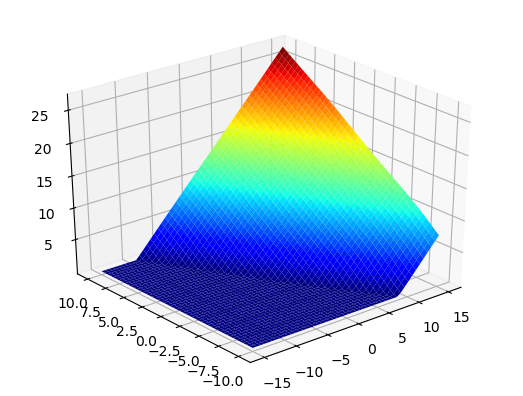

In [53]:
PyPlot.surf(grids..., reshape(X, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:view_init](ax[:elev], 230)

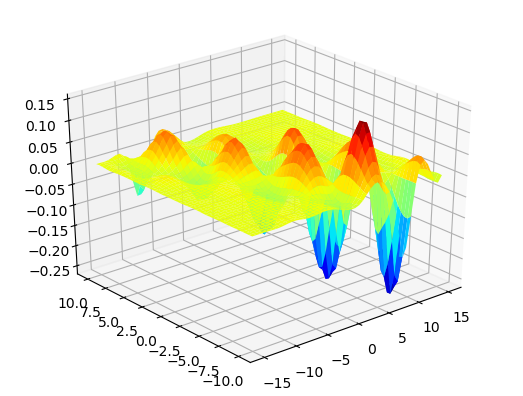

In [54]:
PyPlot.surf(grids..., reshape(resid, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:view_init](ax[:elev], 230)